In [2]:
from openai import AzureOpenAI
import os
from pathlib import Path  
import json
import re
from dotenv import load_dotenv
env_path = Path('.') / 'secrets.env'
load_dotenv(dotenv_path=env_path)
from tenacity import retry, wait_random_exponential, stop_after_attempt, stop_after_delay
openaikey = os.getenv("AZURE_OPENAI_API_KEY")
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")

client = AzureOpenAI(
api_key=openaikey,  
api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
azure_endpoint = openaiservice
)


### Data generation (Skip this step if data is already generated )

In [ ]:
import json  
  
# Load the ontology from the JSON file  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
# Initialize a dictionary to hold the split scenarios  
split_scenarios = {}  
  
# Iterate over each business scenario  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
      
    # Get the metrics specific to this scenario  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                          
                        # Add the tables used by this metric  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
# Print the split scenarios for verification  
for scenario_name, scenario_data in split_scenarios.items():  
    print(f"Scenario: {scenario_name}")  
    print(json.dumps(scenario_data, indent=4))  
    print("\n" + "-"*80 + "\n")  
  
# Optionally, save each scenario to a separate JSON file  
for scenario_name, scenario_data in split_scenarios.items():  
    file_name = f"../data/{scenario_name.replace(' ', '_').lower()}_scenario.json"  
    with open(file_name, "w") as file:  
        json.dump(scenario_data, file, indent=4)  


In [12]:
import json  
import os  
import random  
from tenacity import retry, wait_random_exponential, stop_after_attempt, stop_after_delay  
import openai  
from sklearn.model_selection import train_test_split  
  
# Initialize OpenAI client  
client = openai  
  
# Function to generate business questions and SQL queries  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(5) | stop_after_delay(300)))  
def generate_business_questions_and_queries(schema):  
    user_message = f"""  
        You are training new employees to use the database. Given the following schema and business metrics definitions, generate at least 50 diverse business questions and corresponding SQL queries that can give answer to the question.  
        ##Database schema and Business Metrics Definitions  
        {schema}  
        Try to be creative in the business problem. Use join and aggregate functions to make the question more interesting.  
        Output format: You write the question and sql query into json format as {{"questions": ["question1", "question2"], "sql_queries": ["query for question1", "query for question2"]}}.  
        Your output:  
    """  
  
    response = client.ChatCompletion.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT1"), # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are a data analyst working with a database"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={ "type": "json_object" },  
    )  
    response_message = response.choices[0].message["content"]  
    response_message = json.loads(response_message)  
    assert "questions" in response_message and "sql_queries" in response_message and len(response_message["questions"]) == len(response_message["sql_queries"])  
    return response_message  
  
# Function to review the generated questions and SQL queries  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(5) | stop_after_delay(300)))  
def review_questions_and_queries(schema, questions_and_queries):  
    user_message = f"""  
        You are a SQL expert. Given the following schema and business metrics definitions, and the following business questions and corresponding SQL queries, evaluate the correctness of the SQL queries for each question. If there are any mistakes, provide the correct SQL query.  
        ##Database schema and Business Metrics Definitions  
        {schema}  
        ##Business Questions and SQL Queries  
        {json.dumps(questions_and_queries, indent=4)}  
        Output format: You write the evaluated questions and sql queries into json format as {{"questions": ["question1", "question2"], "sql_queries": ["query for question1", "query for question2"], "reviews": ["review1", "review2"]}}.  
        Your output:  
    """  
  
    response = client.ChatCompletion.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT2"), # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are a SQL expert"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={ "type": "json_object" },  
    )  
    response_message = response.choices[0].message["content"]  
    response_message = json.loads(response_message)  
    assert "questions" in response_message and "sql_queries" in response_message and "reviews" in response_message  
    return response_message  
  
# Function to deduplicate questions and SQL queries  
def deduplicate_questions_and_queries(data):  
    unique_questions = {}  
    for question, query in zip(data["questions"], data["sql_queries"]):  
        if question not in unique_questions:  
            unique_questions[question] = query  
    deduplicated_data = {  
        "questions": list(unique_questions.keys()),  
        "sql_queries": list(unique_questions.values())  
    }  
    return deduplicated_data  
  
# Load the ontology from the JSON file  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
# Initialize a dictionary to hold the split scenarios  
split_scenarios = {}  
  
# Iterate over each business scenario  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
      
    # Get the metrics specific to this scenario  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                          
                        # Add the tables used by this metric  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
# Generate and review questions and queries for each scenario  
all_scenarios_output = {}  
all_data = []  
for scenario_name, scenario_data in split_scenarios.items():  
    schema = json.dumps(scenario_data, indent=4)  
    consolidated_questions_and_queries = {  
        "questions": [],  
        "sql_queries": []  
    }  
      
    # Run the generation 10 times  
    for _ in range(10):  
        # Generate business questions and SQL queries  
        generated_data = generate_business_questions_and_queries(schema)  
          
        # Append generated questions and queries to consolidated list  
        consolidated_questions_and_queries["questions"].extend(generated_data["questions"])  
        consolidated_questions_and_queries["sql_queries"].extend(generated_data["sql_queries"])  
      
    # Deduplicate questions and queries  
    deduplicated_data = deduplicate_questions_and_queries(consolidated_questions_and_queries)  
      
    # Review the deduplicated questions and SQL queries  
    reviewed_data = review_questions_and_queries(schema, deduplicated_data)  
      
    # Store the reviewed data in the consolidated output  
    all_scenarios_output[scenario_name] = reviewed_data  
  
    # Prepare data for train-test split  
    for question, query in zip(reviewed_data["questions"], reviewed_data["sql_queries"]):  
        all_data.append({  
            "scenario": scenario_name,  
            "input": question,  
            "output": query  
        })  
  
# Stratify train-test split by scenario  
train, test = train_test_split(all_data, test_size=0.2, stratify=[item["scenario"] for item in all_data])  
  
# Save train and test data to JSONL files  
with open("../llama2/data/sqltrain_openai.jsonl", "w") as f:  
    for item in train:  
        f.write(json.dumps({"messages": [{"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"}, {"role": "user", "content": item["input"]}, {"role": "assistant", "content": item["output"]}]}) + "\n")  
  
with open("../llama2/data/sqltest_openai.jsonl", "w") as f:  
    for item in test:  
        f.write(json.dumps({"messages": [{"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"}, {"role": "user", "content": item["input"]}, {"role": "assistant", "content": item["output"]}]}) + "\n")  


RetryError: RetryError[<Future at 0x1fe7305e890 state=finished raised APIRemovedInV1>]

In [14]:
import json  
import random  
from sklearn.model_selection import train_test_split  
  
# Load all scenarios' data from JSON file  
with open("../data/all_scenarios_questions_and_queries.json", "r") as file:  
    all_scenarios_output = json.load(file)  
  
# Prepare a consolidated list of all data  
all_data = []  
for scenario_name, scenario_data in all_scenarios_output.items():  
    for question, query in zip(scenario_data["questions"], scenario_data["sql_queries"]):  
        all_data.append({  
            "scenario": scenario_name,  
            "input": question,  
            "output": query  
        })  
  
# Stratify train-test split by scenario  
train, test = train_test_split(all_data, test_size=0.2, stratify=[item["scenario"] for item in all_data])  
  
# Save train and test data to JSONL files  
with open("../data/sqltrain_openai.jsonl", "w") as f:  
    for item in train:  
        f.write(json.dumps({"messages": [{"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"}, {"role": "user", "content": item["input"]}, {"role": "assistant", "content": item["output"]}]}) + "\n")  
  
with open("../data/sqltest_openai.jsonl", "w") as f:  
    for item in test:  
        f.write(json.dumps({"messages": [{"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"}, {"role": "user", "content": item["input"]}, {"role": "assistant", "content": item["output"]}]}) + "\n")  



Accuracy by Scenario:

Accuracy for no_context:
  Scenario: Order Analysis, Accuracy: 75.00%
  Scenario: Supplier Analysis, Accuracy: 68.42%
  Scenario: Shipping Analysis, Accuracy: 84.21%
  Scenario: Inventory Management, Accuracy: 89.47%
  Scenario: Product Analysis, Accuracy: 78.95%
  Scenario: Customer Analysis, Accuracy: 73.68%
  Scenario: cross_scenario, Accuracy: 65.00%
  Scenario: Employee Performance, Accuracy: 68.42%
  Overall Accuracy: 75.32%

Accuracy for with_context_ft:
  Scenario: Order Analysis, Accuracy: 90.00%
  Scenario: Supplier Analysis, Accuracy: 89.47%
  Scenario: Shipping Analysis, Accuracy: 73.68%
  Scenario: Inventory Management, Accuracy: 78.95%
  Scenario: Product Analysis, Accuracy: 89.47%
  Scenario: Customer Analysis, Accuracy: 73.68%
  Scenario: cross_scenario, Accuracy: 65.00%
  Scenario: Employee Performance, Accuracy: 73.68%
  Overall Accuracy: 79.22%

Accuracy for with_context_base:
  Scenario: Order Analysis, Accuracy: 85.00%
  Scenario: Supplier A

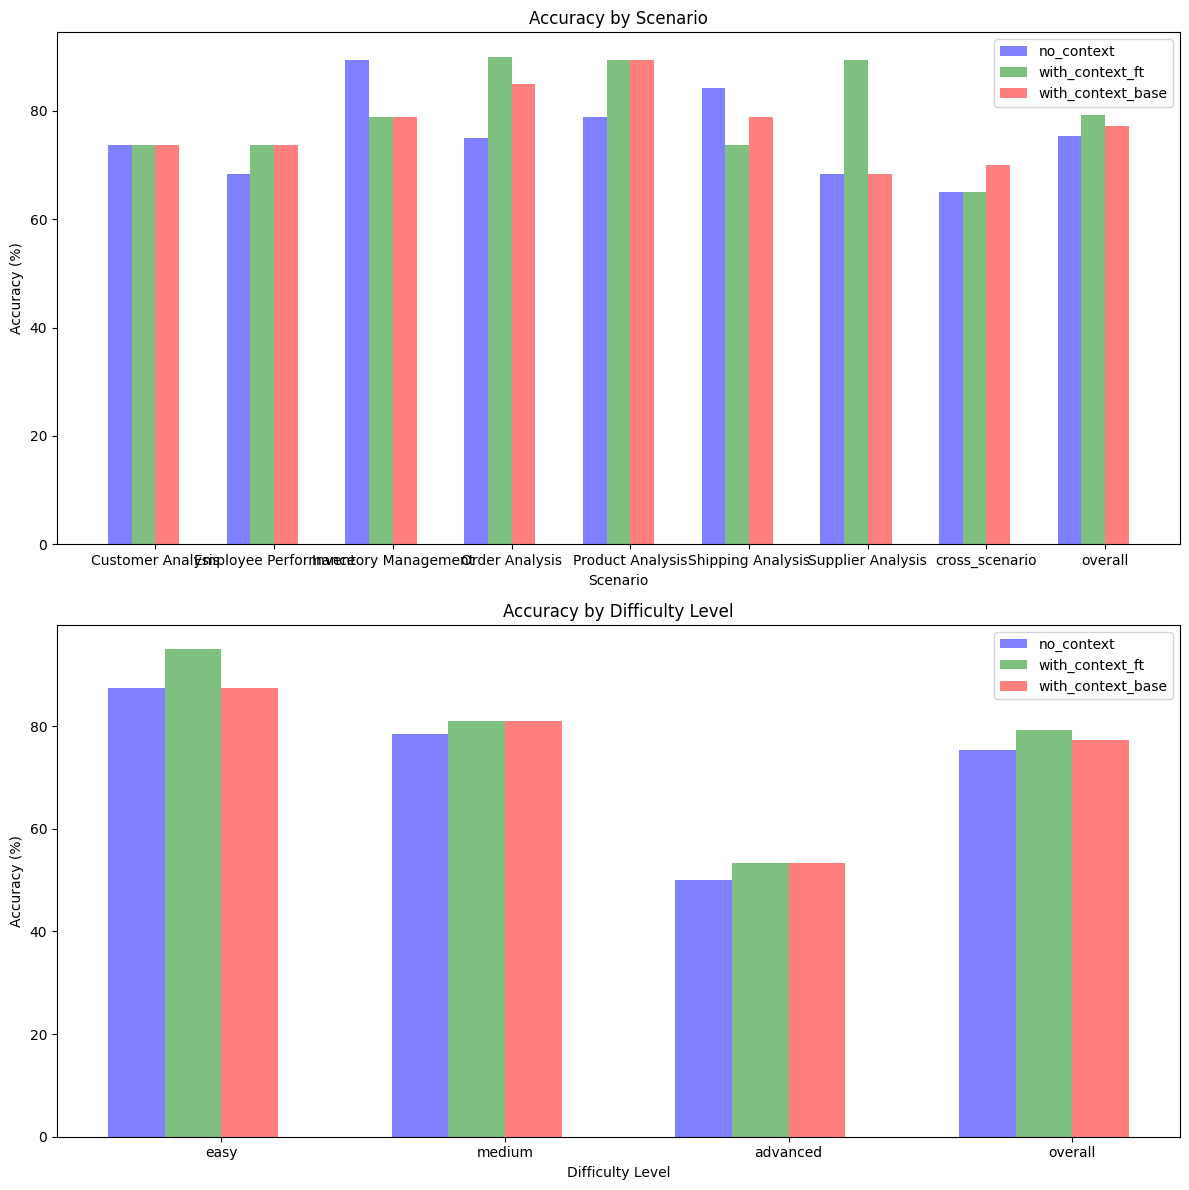

In [25]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
  
# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
# Initialize OpenAI client  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  

# Load the test dataset  
with open("../data/test_data.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
schema = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model without context  
def generate_sql_query_no_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate SQL queries using the second OpenAI model  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would correctly answer the user's question. The generated query does not have to be identical to the ground truth query.  
    ## User Question  
    {question}  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Your output:  
    """  
  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are a SQL expert"},  
            {"role": "user", "content": user_message},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content.strip().lower()  
    return response_message  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "no_context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "with_context_ft": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "with_context_base": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model without context  
    generated_query_no_context = generate_sql_query_no_context(question)  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_context(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_no_context = evaluate_sql_query(question, generated_query_no_context, ground_truth_query)  
    evaluation_result_with_context_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for no context  
    results_by_setup["no_context"][scenario]["total"] += 1  
    results_by_setup["no_context"][difficulty]["total"] += 1  
    if evaluation_result_no_context == 'yes':  
        results_by_setup["no_context"][scenario]["correct"] += 1  
        results_by_setup["no_context"][difficulty]["correct"] += 1  
  
    # Update results for context with fine-tuned model  
    results_by_setup["with_context_ft"][scenario]["total"] += 1  
    results_by_setup["with_context_ft"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["with_context_ft"][scenario]["correct"] += 1  
        results_by_setup["with_context_ft"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["with_context_base"][scenario]["total"] += 1  
    results_by_setup["with_context_base"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["with_context_base"][scenario]["correct"] += 1  
        results_by_setup["with_context_base"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["no_context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
  
axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios)  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
  
axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties)  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  



Accuracy by Scenario:

Accuracy for no_context:
  Scenario: Order Analysis, Accuracy: 90.00%
  Scenario: Supplier Analysis, Accuracy: 84.21%
  Scenario: Shipping Analysis, Accuracy: 89.47%
  Scenario: Inventory Management, Accuracy: 68.42%
  Scenario: Product Analysis, Accuracy: 68.42%
  Scenario: Customer Analysis, Accuracy: 68.42%
  Scenario: cross_scenario, Accuracy: 50.00%
  Scenario: Employee Performance, Accuracy: 63.16%
  Overall Accuracy: 72.73%

Accuracy for with_context_ft:
  Scenario: Order Analysis, Accuracy: 85.00%
  Scenario: Supplier Analysis, Accuracy: 73.68%
  Scenario: Shipping Analysis, Accuracy: 78.95%
  Scenario: Inventory Management, Accuracy: 89.47%
  Scenario: Product Analysis, Accuracy: 78.95%
  Scenario: Customer Analysis, Accuracy: 73.68%
  Scenario: cross_scenario, Accuracy: 80.00%
  Scenario: Employee Performance, Accuracy: 73.68%
  Overall Accuracy: 79.22%

Accuracy for with_context_base:
  Scenario: Order Analysis, Accuracy: 90.00%
  Scenario: Supplier A

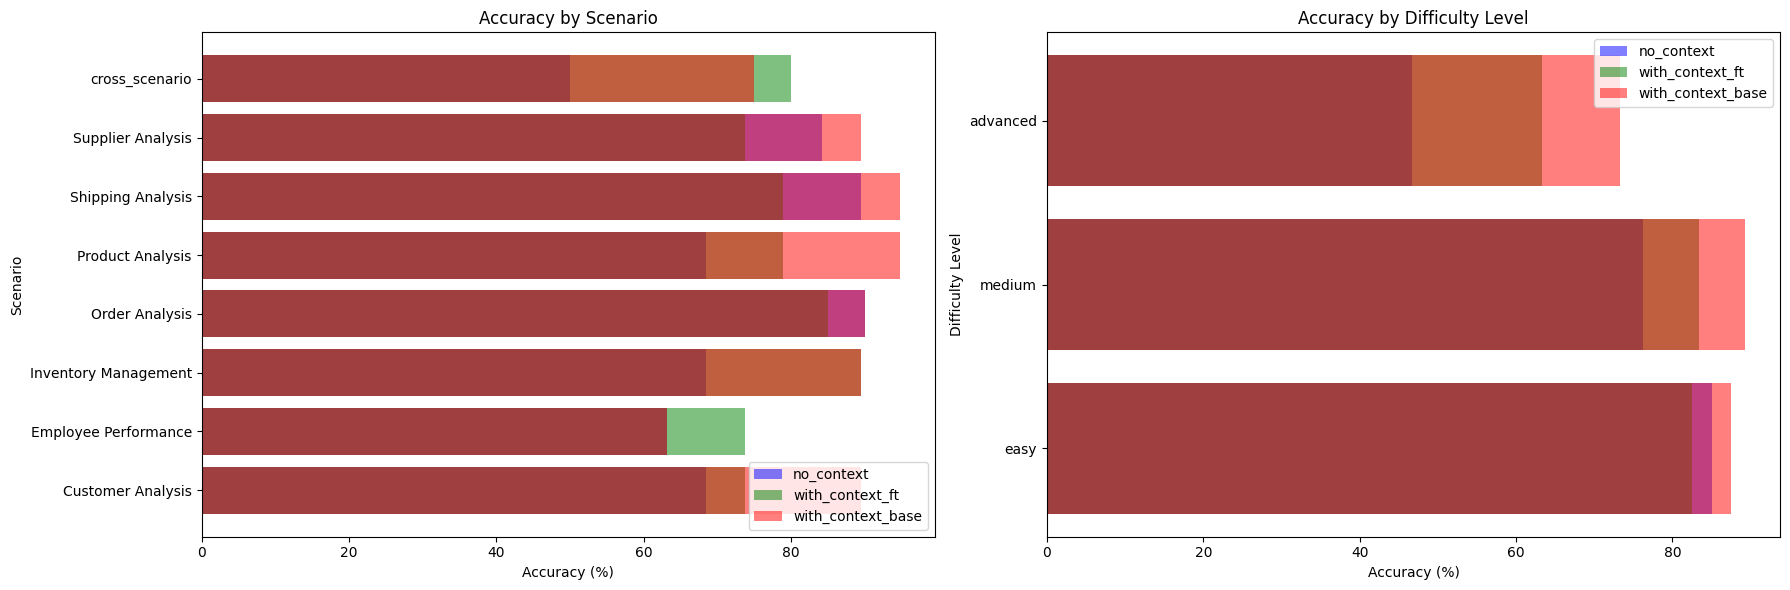

In [21]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
  
# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  

# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
  
# Load the test dataset  
with open("../data/test_data.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
schema = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model without context  
def generate_sql_query_no_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate SQL queries using the second OpenAI model  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would correctly answer the user's question. The generated query does not have to be identical to the ground truth query.  
    ## User Question  
    {question}  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Your output:  
    """  
  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are a SQL expert"},  
            {"role": "user", "content": user_message},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content.strip().lower()  
    return response_message  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "no_context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "with_context_ft": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "with_context_base": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model without context  
    generated_query_no_context = generate_sql_query_no_context(question)  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_context(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_no_context = evaluate_sql_query(question, generated_query_no_context, ground_truth_query)  
    evaluation_result_with_context_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for no context  
    results_by_setup["no_context"][scenario]["total"] += 1  
    results_by_setup["no_context"][difficulty]["total"] += 1  
    if evaluation_result_no_context == 'yes':  
        results_by_setup["no_context"][scenario]["correct"] += 1  
        results_by_setup["no_context"][difficulty]["correct"] += 1  
  
    # Update results for context with fine-tuned model  
    results_by_setup["with_context_ft"][scenario]["total"] += 1  
    results_by_setup["with_context_ft"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["with_context_ft"][scenario]["correct"] += 1  
        results_by_setup["with_context_ft"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["with_context_base"][scenario]["total"] += 1  
    results_by_setup["with_context_base"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["with_context_base"][scenario]["correct"] += 1  
        results_by_setup["with_context_base"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  
  
# Plot accuracy by scenario  
scenario_names = sorted(set(s for s in results_by_setup["no_context"] if s not in ["easy", "medium", "advanced"]))  
for setup_name, color in zip(results_by_setup.keys(), ['blue', 'green', 'red']):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names]  
    axes[0].barh(scenario_names, scenario_accuracies, color=color, alpha=0.5, label=setup_name)  
  
axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Accuracy (%)')  
axes[0].set_ylabel('Scenario')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
difficulty_levels = ["easy", "medium", "advanced"]  
for setup_name, color in zip(results_by_setup.keys(), ['blue', 'green', 'red']):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels]  
    axes[1].barh(difficulty_levels, difficulty_accuracies, color=color, alpha=0.5, label=setup_name)  
  
axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Accuracy (%)')  
axes[1].set_ylabel('Difficulty Level')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  



Accuracy by Scenario:

Accuracy for no_context:
  Scenario: Order Analysis, Accuracy: 90.00%
  Scenario: Supplier Analysis, Accuracy: 84.21%
  Scenario: Shipping Analysis, Accuracy: 89.47%
  Scenario: Inventory Management, Accuracy: 68.42%
  Scenario: Product Analysis, Accuracy: 68.42%
  Scenario: Customer Analysis, Accuracy: 68.42%
  Scenario: cross_scenario, Accuracy: 50.00%
  Scenario: Employee Performance, Accuracy: 63.16%
  Scenario: overall_scenario, Accuracy: 72.73%
  Scenario: overall_difficulty, Accuracy: 72.73%
  Overall Accuracy: 72.73%

Accuracy for with_context_ft:
  Scenario: Order Analysis, Accuracy: 85.00%
  Scenario: Supplier Analysis, Accuracy: 73.68%
  Scenario: Shipping Analysis, Accuracy: 78.95%
  Scenario: Inventory Management, Accuracy: 89.47%
  Scenario: Product Analysis, Accuracy: 78.95%
  Scenario: Customer Analysis, Accuracy: 73.68%
  Scenario: cross_scenario, Accuracy: 80.00%
  Scenario: Employee Performance, Accuracy: 73.68%
  Scenario: overall_scenario, A

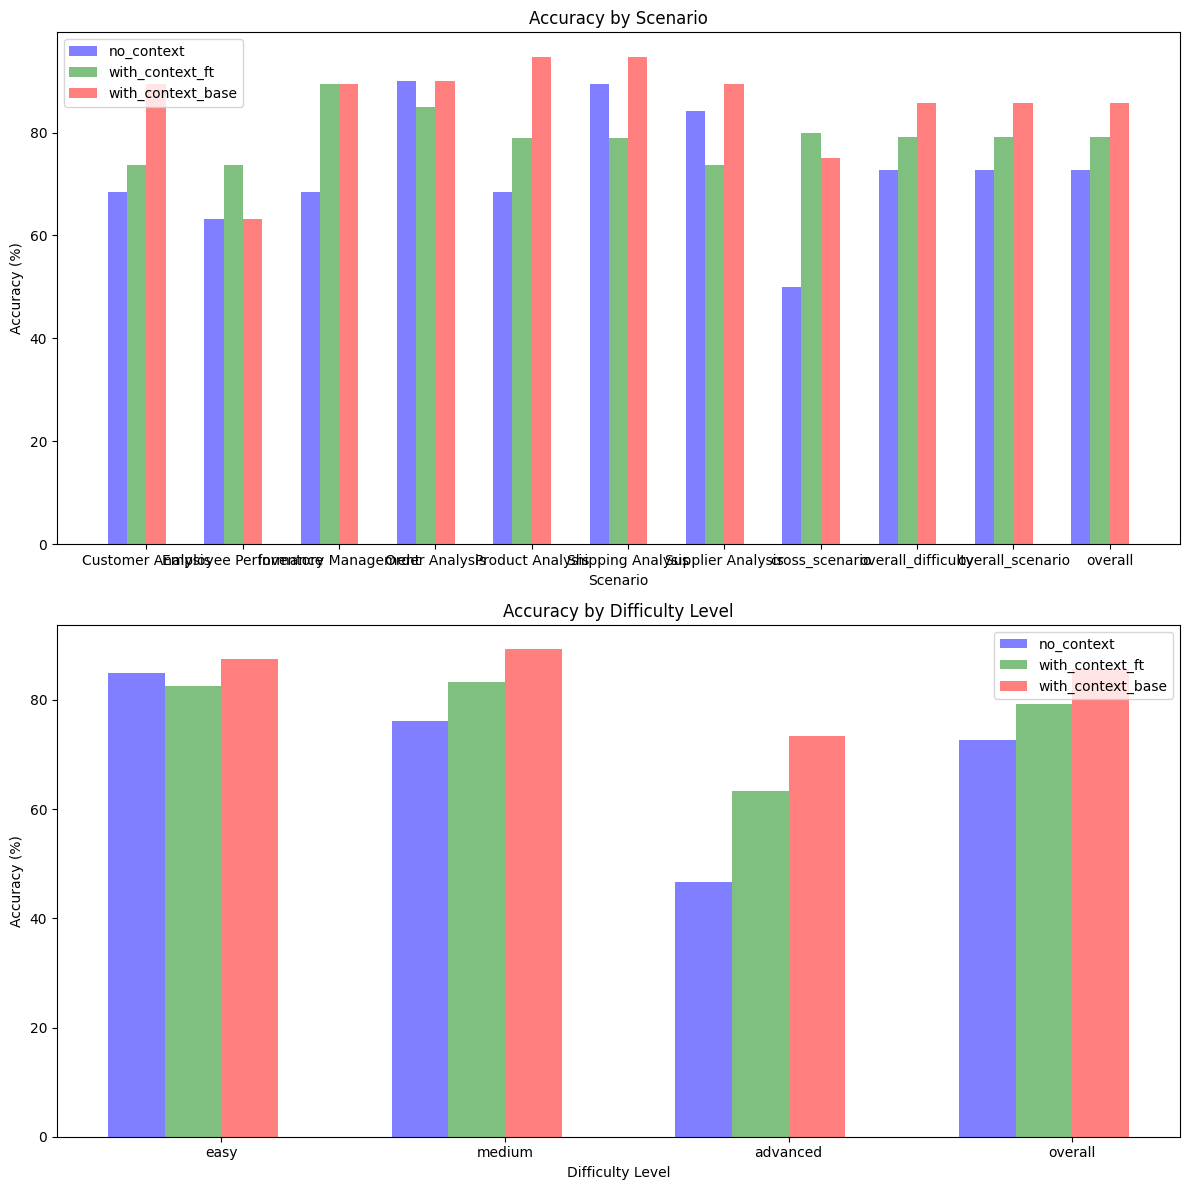

In [24]:
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["no_context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
  
axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios)  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
  
axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties)  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  


In [28]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
  
# Load environment variables  
env_path = Path('.') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/test_data.json", "r") as file:  
    test_data = json.load(file)  
# Load the schema information  
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
schema = json.dumps(ontology, indent=4)  
  
# Function to generate SQL queries using the first OpenAI model without context  
def generate_sql_query_no_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the first OpenAI model with context  
def generate_sql_query_with_context(question):  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT2"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to generate SQL queries using the base OpenAI model with context  
def generate_sql_query_base_model_with_context(question):  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  # engine = "deployment_name".  
        messages=[  
            {"role": "system", "content": f"You are querying the MDDX database. Use the following schema: {schema}. What is the SQL query for the following question?"},  
            {"role": "user", "content": question},  
        ],  
        timeout=90,  
    )  
    response_message = response.choices[0].message.content  
    return response_message  
  
# Function to evaluate SQL queries using the second OpenAI model  
def evaluate_sql_query(question, generated_query, ground_truth_query):  
    user_message = f"""  
    You are a SQL expert. Given the following user question, generated SQL query, and the ground truth SQL query, evaluate whether the generated SQL query would correctly answer the user's question. The generated query does not have to be identical to the ground truth query.  
    ## User Question  
    {question}  
    ## Generated SQL Query  
    {generated_query}  
    ## Ground Truth SQL Query  
    {ground_truth_query}  
    Output format: Provide a single word answer as 'yes' or 'no'.  
    Your output:  
    """  
      
    votes = []  
    for _ in range(3):  
        response = client.chat.completions.create(  
            model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  # engine = "deployment_name".  
            messages=[  
                {"role": "system", "content": "You are a SQL expert"},  
                {"role": "user", "content": user_message},  
            ],  
            timeout=90,  
        )  
        response_message = response.choices[0].message.content.strip().lower()  
        votes.append(response_message)  
      
    # Take the majority vote  
    return 'yes' if votes.count('yes') > votes.count('no') else 'no'  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "FT_No_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "FT_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Base_With_Context": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# Generate SQL queries and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    question = item["input"]  
    ground_truth_query = item["output"]  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    # Generate SQL query using the first model without context  
    generated_query_no_context = generate_sql_query_no_context(question)  
  
    # Generate SQL query using the first model with context  
    generated_query_with_context_ft = generate_sql_query_with_context(question)  
  
    # Generate SQL query using the base model with context  
    generated_query_with_context_base = generate_sql_query_base_model_with_context(question)  
  
    # Evaluate the generated queries using the second model  
    evaluation_result_no_context = evaluate_sql_query(question, generated_query_no_context, ground_truth_query)  
    evaluation_result_with_context_ft = evaluate_sql_query(question, generated_query_with_context_ft, ground_truth_query)  
    evaluation_result_with_context_base = evaluate_sql_query(question, generated_query_with_context_base, ground_truth_query)  
  
    # Update results for no context  
    results_by_setup["FT_No_Context"][scenario]["total"] += 1  
    results_by_setup["FT_No_Context"][difficulty]["total"] += 1  
    if evaluation_result_no_context == 'yes':  
        results_by_setup["FT_No_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_No_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with fine-tuned model  
    results_by_setup["FT_With_Context"][scenario]["total"] += 1  
    results_by_setup["FT_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_ft == 'yes':  
        results_by_setup["FT_With_Context"][scenario]["correct"] += 1  
        results_by_setup["FT_With_Context"][difficulty]["correct"] += 1  
  
    # Update results for context with base model  
    results_by_setup["Base_With_Context"][scenario]["total"] += 1  
    results_by_setup["Base_With_Context"][difficulty]["total"] += 1  
    if evaluation_result_with_context_base == 'yes':  
        results_by_setup["Base_With_Context"][scenario]["correct"] += 1  
        results_by_setup["Base_With_Context"][difficulty]["correct"] += 1  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["FT_No_Context"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    scenario_accuracies = [(results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'green', 'red'])):  
    difficulty_accuracies = [(results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  


NotFoundError: Error code: 404 - {'error': {'code': 'DeploymentNotFound', 'message': 'The API deployment for this resource does not exist. If you created the deployment within the last 5 minutes, please wait a moment and try again.'}}

In [30]:
with open("../data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  

split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  

split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  

all_scenarios_output = {}  
with open("../data/all_scenarios_questions_and_queries.json", "r") as file:  
    all_scenarios_output = json.load(file)  

all_data = []  
for scenario_name, reviewed_data in all_scenarios_output.items():  
    for question, query, difficulty in zip(reviewed_data["questions"], reviewed_data["sql_queries"], reviewed_data["difficulty"]):  
        all_data.append({  
            "scenario": scenario_name,  
            "input": question,  
            "output": query,  
            "difficulty": difficulty  
        })  
  
train, test = train_test_split(all_data, test_size=0.2, stratify=[item["scenario"] for item in all_data])  

  
def create_message_format(item, schema, include_context=True):  
    schema_context = f"## Database Schema and Business Metrics Definitions\n{schema}\n\n## Question: " if include_context else ""  
    user_content = f"{schema_context}{item['input']}"  
    return {  
        "messages": [  
            {"role": "system", "content": "You are querying the MDDX database, what is the SQL query for the following question?"},  
            {"role": "user", "content": user_content},  
            {"role": "assistant", "content": item["output"]}  
        ]  
    }  

with open("../data/sqltrain_openai_v3.jsonl", "w") as f:  
    for item in train:  
        schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
        f.write(json.dumps(create_message_format(item, schema)) + "\n")  

with open("../data/sqltest_openai_v3.jsonl", "w") as f:  
    for item in test:  
        schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
        f.write(json.dumps(create_message_format(item, schema)) + "\n")  

with open("../data/train_data_v3.json", "w") as f:  
    json.dump(train, f, indent=4)  

with open("../data/test_data_v3.json", "w") as f:  
    json.dump(test, f, indent=4)  

